# Foot Traffic Data Analysis

In [1]:
import numpy as np
import pandas as pd

In [25]:
stores = pd.read_csv("data/db/stores.csv", dtype={"store_id":"string"})
customers = pd.read_csv("data/db/customers.csv", dtype={"customer_id":"string"})

visits = pd.read_csv("data/db/visits.csv", dtype={"customer_id":"string", "store_id":"string"})\
    .merge(stores, on="store_id", how="left")\
    .merge(customers, on="customer_id", how="left")

visits["visit_date"] = pd.to_datetime(visits["visit_date"])

display(stores.head())
display(customers.head())
display(visits.head())

,store_id,opened_date,latitude,longitude,store_address,city,state
0,4857,2016-09-12,42.58342,-71.80230,517 Main Street,Fitchburg,Massachusetts
1,2596,2018-10-12,34.06635,-84.67837,2728 North Main Street,Acworth,Georgia
2,7070,2015-12-04,40.63316,-74.13653,8895 Port Richmond Avenue,City of New York,New York
3,6525,2015-12-09,34.21639,-119.03760,269 Ventura Boulevard,Camarillo,California
4,7424,2022-02-02,33.44872,-86.78777,7182 Tyson Drive,Vestavia Hills,Alabama


,customer_id,customer_name,customer_birthday,customer_email,is_member,card_on_file
0,d2a21b4f,Annette Morton,1932-12-01,wmartin@yahoo.com,True,American Express
1,05e6b6f9,Linda Adams,1927-07-18,greenrebecca@miller.com,True,VISA 16 digit
2,ea609017,Eric Wood,1914-09-23,joneswilliam@yahoo.com,True,VISA 19 digit
3,22d03a03,Peter Moore,1998-05-31,ismith@gordon.net,True,Maestro
4,fd08c7b8,Ricky Green,2008-04-08,hollygoodwin@delgado-greer.org,True,JCB 15 digit


,visit_id,visit_date,store_id,customer_id,order_total,payment_method,opened_date,latitude,longitude,store_address,city,state,customer_name,customer_birthday,customer_email,is_member,card_on_file
0,075143e5,2020-01-01,2574,00504361,137.44,cash,2011-04-10,33.44872,-86.78777,7987 Tyson Drive,Vestavia Hills,Alabama,Rachel Carroll,1972-06-19,meganmartin@baker.com,True,JCB 16 digit
1,7795cda5,2020-01-01,2971,8b698701,8.79,credit,2008-08-26,43.91452,-69.96533,5519 Pleasant Street,Brunswick,Maine,Anne Cook,1952-05-11,sweeneycheryl@yahoo.com,False,Diners Club / Carte Blanche
2,a913aabc,2020-01-01,900,4a59e47d,1.72,cash,2000-10-02,40.72816,-74.07764,3760 Olean Avenue,Jersey City,New Jersey,Jasmine English,1953-08-19,jose35@warren-campbell.biz,True,Discover
3,a68e3778,2020-01-01,7070,89d5157a,8.88,credit,2015-12-04,40.63316,-74.13653,8895 Port Richmond Avenue,City of New York,New York,Zachary Hale,1987-06-28,twilcox@reynolds.com,False,JCB 16 digit
4,9be7cdd9,2020-01-01,825,253dd271,453.49,credit,2011-11-22,41.14676,-73.49484,3463 Elm Street,New Canaan,Connecticut,Alyssa Leonard,1984-08-15,patriciasmith@gmail.com,True,VISA 16 digit


## Calculating a time series of total visits by day

In [10]:
visits.groupby("visit_date").size()\
    .reset_index().rename(columns={0:"visit_count"})

,visit_date,visit_count
0,2020-01-01,1550
1,2020-01-02,5460
2,2020-01-03,4187
3,2020-01-04,3012
4,2020-01-05,8394
...,...,...
148,2020-05-28,3811
149,2020-05-29,4862
150,2020-05-30,2725
151,2020-05-31,6153


In [22]:
visits[["visit_date", "order_total"]].groupby("visit_date").sum()

,order_total
visit_date,
2020-01-01,307073.74
2020-01-02,1103738.21
2020-01-03,848534.26
2020-01-04,608826.66
2020-01-05,1698731.57
...,...
2020-05-28,754263.46
2020-05-29,972947.93
2020-05-30,542620.44


C:\Users\kah32\AppData\Local\Temp\ipykernel_11148\1118377836.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  visits.set_index("visit_date").resample("2W").mean()["order_total"].plot()


<AxesSubplot: xlabel='visit_date'>

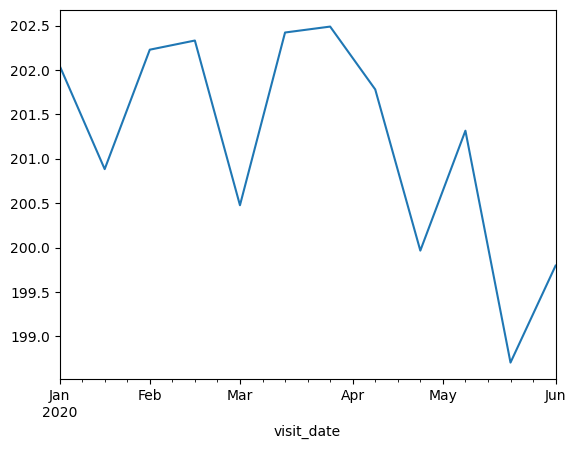

In [32]:
visits.set_index("visit_date").resample("2W").mean()["order_total"].plot()

In [33]:
visits.head()

,visit_id,visit_date,store_id,customer_id,order_total,payment_method,opened_date,latitude,longitude,store_address,city,state,customer_name,customer_birthday,customer_email,is_member,card_on_file
0,075143e5,2020-01-01,2574,00504361,137.44,cash,2011-04-10,33.44872,-86.78777,7987 Tyson Drive,Vestavia Hills,Alabama,Rachel Carroll,1972-06-19,meganmartin@baker.com,True,JCB 16 digit
1,7795cda5,2020-01-01,2971,8b698701,8.79,credit,2008-08-26,43.91452,-69.96533,5519 Pleasant Street,Brunswick,Maine,Anne Cook,1952-05-11,sweeneycheryl@yahoo.com,False,Diners Club / Carte Blanche
2,a913aabc,2020-01-01,900,4a59e47d,1.72,cash,2000-10-02,40.72816,-74.07764,3760 Olean Avenue,Jersey City,New Jersey,Jasmine English,1953-08-19,jose35@warren-campbell.biz,True,Discover
3,a68e3778,2020-01-01,7070,89d5157a,8.88,credit,2015-12-04,40.63316,-74.13653,8895 Port Richmond Avenue,City of New York,New York,Zachary Hale,1987-06-28,twilcox@reynolds.com,False,JCB 16 digit
4,9be7cdd9,2020-01-01,825,253dd271,453.49,credit,2011-11-22,41.14676,-73.49484,3463 Elm Street,New Canaan,Connecticut,Alyssa Leonard,1984-08-15,patriciasmith@gmail.com,True,VISA 16 digit


In [63]:
members = visits[visits["is_member"] == True]
mtiers = members.groupby("customer_id").sum()["order_total"].reset_index()
mtiers["membership_tier"] = pd.qcut(mtiers["order_total"], [0,0.5, 0.85, 0.95], labels=["bronze", "silver", "gold"])
df = visits.merge(mtiers[["customer_id", "membership_tier"]], on="customer_id", how="left")
df["membership_tier"] = df["membership_tier"].astype("string").fillna("Nonmember").astype("category")
df.groupby(["visit_date", "membership_tier"]).mean()["order_total"].unstack()#.plot()

C:\Users\kah32\AppData\Local\Temp\ipykernel_11148\379259667.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mtiers = members.groupby("customer_id").sum()["order_total"].reset_index()
C:\Users\kah32\AppData\Local\Temp\ipykernel_11148\379259667.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(["visit_date", "membership_tier"]).mean()["order_total"].unstack()#.plot()


membership_tier,Nonmember,bronze,gold,silver
visit_date,,,,
2020-01-01,209.083002,172.056194,215.965000,191.318034
2020-01-02,203.848384,183.402585,207.485614,221.248342
2020-01-03,202.549063,196.222527,222.597192,206.331362
2020-01-04,204.140418,192.539490,231.781185,201.225846
2020-01-05,201.445870,195.919103,211.871829,210.874027
...,...,...,...,...
2020-05-28,197.150340,188.538383,205.981150,211.517717
2020-05-29,204.795752,193.929577,190.307873,197.632071
2020-05-30,196.246242,193.788100,212.224648,211.483625
